In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from joblib import Parallel, delayed

In [ ]:
def load_matrix(filepath="problems/problem_r2_100.npy"):
    matrix = np.load(filepath)

    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Distance matrix must be square (n x n).")
    return matrix

In [ ]:
def is_feasible(tour, n_cities):
    """ 
    Check if a tour is a valid permutation of all cities.

    Parameters:
    tour: np.ndarray 1D array representing the order of cities visited
    n_cities: int total number of cities

    Return:
    bool True if the tour is feasible, False otherwise
    """

    if len(tour) != n_cities:
        return False
    
    #Check that all cities appear exactly once
    return np.array_equal(np.sort(tour), np.arange(n_cities))

In [20]:
def compute_fitness(tour, distance_matrix):
    """ 
    Compute the toatl distance of a TSP tour.

    Parameters:
    tour: np.ndarray 1D array representing the order of cities visited
    distance_matrix: np.ndarray 2D array of pairwise distances

    Return:
    float total length of the tour
    """

    if not is_feasible(tour, len(distance_matrix)):
        raise ValueError("Invalid tour: not a feasible permutation.")
    
    return np.sum(distance_matrix[tour, np.roll(tour, -1)])


In [43]:
def initialize_population(pop_size, n_cities):
    population = [np.random.permutation(n_cities) for _ in range(pop_size)]
    return population

def tournament_selection(population, fitnesses, k=3):
    "Select one parent using tournament selection"
    selected_indices = np.random.choice(len(population), k, replace=False)
    selected_fitnesses = [fitnesses[i] for i in selected_indices]
    winner_index = selected_indices[np.argmin(selected_fitnesses)]
    return population[winner_index].copy()

def ordered_crossover(parent1, parent2):
    "Perform ordered crossover betweem two parent tours"
    n = len(parent1)
    a, b = sorted(np.random.choice(n, 2, replace=False))

    child = [-1] * n
    #Copy segment from parent1
    child[a:b] = parent1[a:b]

    #Take cities in parent2 not taken from parent1
    p2_items = [city for city in parent2 if city not in child]

    #Fill remaining positions
    j=0
    for i in range(n):
        if child[i]==-1:
            child[i] = p2_items[j]
            j += 1

    return np.array(child)

def swap_mutation(tour, mutation_rate=0.2):
    "Swap two cities in the tour with a given probability"
    new_tour = tour.copy()
    if np.random.rand() < mutation_rate:
        i, j = np.random.choice(len(tour), 2, replace=False)
        new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

def two_opt_mutation(tour, mutation_rate=0.1):
    "Perform a 2-opt mutation with a given probability"
    new_tour = tour.copy()
    if np.random.rand() < mutation_rate:
        i, j = sorted(np.random.choice(len(tour), 2, replace=False))
        new_tour[i:j] = new_tour[i:j][::-1]
    return new_tour



In [74]:
def plot_tour(tour, distance_matrix, city_labels=None):
    """ 
    Plot a TSP tour in 2D using Multidimensional Scaling (MDS)
    to approximate coordinate from the distance matrix
    """
    n = distance_matrix.shape[0]

    distance_matrix = (distance_matrix + distance_matrix.T) / 2  #makes the matrix symmetric
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_init=4)
    coords = mds.fit_transform(distance_matrix)

    tour_coords = coords[tour]
    tour_coords = np.vstack([tour_coords, tour_coords[0]])

    plt.figure(figsize=(8, 6))
    plt.plot(tour_coords[:, 0], tour_coords[:, 1], '-o', markersize=8)

    if city_labels is not None:
        for i, city in enumerate(tour):
            plt.text(coords[city, 0], coords[city, 1], city_labels[city], fontsize=9)

    plt.title("TSP Tour Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [ ]:
def genetic_algorithm(distance_matrix, pop_size=100, generations=500, crossover_rate=0.8, mutation_rate=0.2, elite_size=1):
    """ 
    Genetic algorithm for solving a general TSP
    """

    n_cities = distance_matrix.shape[0]

    #Initialization
    population = initialize_population(pop_size, n_cities)
    fitnesses = [compute_fitness(tour, distance_matrix) for tour in population]

    #Track best solution
    best_idx = np.argmin(fitnesses)
    best_tour = population[best_idx].copy()
    best_fitness = fitnesses[best_idx]
    history = [best_fitness]

    #Main loop
    for gen in range (1, generations+1):
        new_population = []

        #Elitism
        elite_indices = np.argsort(fitnesses)[:elite_size]
        elites = [population[i].copy() for i in elite_indices]
        new_population.extend(elites)

        #Generate offspring
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)

            #Crossover
            if np.random.rand() < crossover_rate:
                child = ordered_crossover(parent1, parent2)
            else:
                child = parent1.copy()

            #Mutation
            child = swap_mutation(child, mutation_rate)
            child = two_opt_mutation(child, mutation_rate=0.1)

            new_population.append(child)

        #Evaluate new population
        population = new_population
        fitnesses = [compute_fitness(tour, distance_matrix) for tour in population]

        #Track best solution
        gen_best_idx = np.argmin(fitnesses)
        gen_best_fitness = fitnesses[gen_best_idx]

        if gen_best_fitness < best_fitness:
            best_fitness = gen_best_fitness
            best_tour = population[gen_best_idx].copy()

        history.append(best_fitness)

    #Plot convergence
    plt.figure(figsize=(8,5))
    plt.plot(history, color='blue')
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness (Distance)")
    plt.title("GA Convergence Curve")
    plt.grid(True)
    plt.show()

    return best_tour, best_fitness

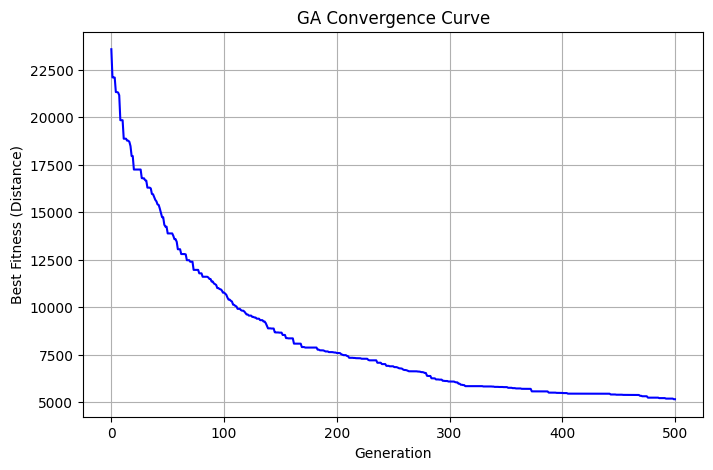

Best distance: 5148.179517074724


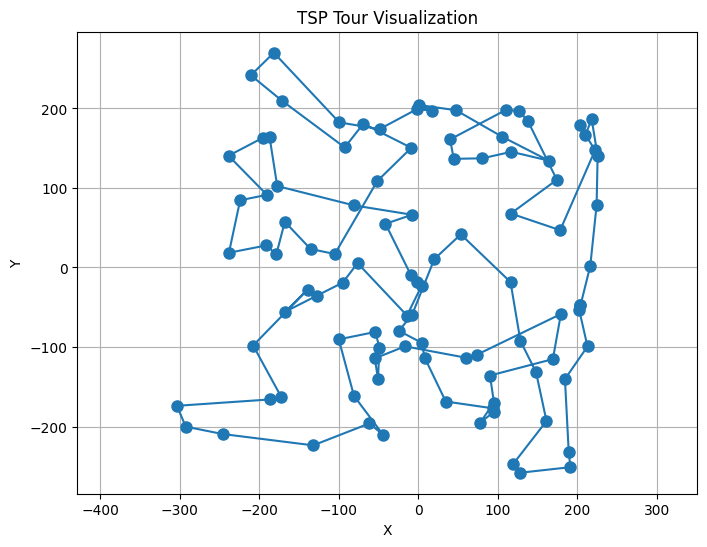

In [58]:
problem = load_matrix()
best_tour, best_distance = genetic_algorithm(distance_matrix=problem,
                                             pop_size=100,
                                             generations=500,
                                             crossover_rate=0.9,
                                             mutation_rate=0.2,
                                             elite_size=2)
print("Best distance:", best_distance)

plot_tour(best_tour, problem)

Following starts the code for the advanced genetic algortithm

In [ ]:
def greedy_initialization(pop_size, n_cities, distance_matrix, greedy_fraction=0.5):
    "Mixed initialization: greedy + random tours"
    population = []

    #Greedy initialization
    n_greedy = int(pop_size * greedy_fraction)
    for _ in range(n_greedy):
        start = np.random.randint(n_cities)
        tour = [start]
        remaining = list(set(range(n_cities)) - set(tour))
        while remaining:
            last = tour[-1]
            next_city = remaining[np.argmin(distance_matrix[last, remaining])]
            tour.append(next_city)
            remaining.remove(next_city)
        population.append(np.array(tour))

    #Random tours
    for _ in range(pop_size - n_greedy):
        population.append(np.random.permutation(n_cities))

    return population

def edge_recombination_crossover(parent1, parent2):
    "Edge Recombination Crossover for TSP"
    n = len(parent1)
    edges = {i: set() for i in range(n)}

    for p in [parent1, parent2]:
        for i in range(n):
            edges[p[i]].update([p[i-1], p[(i+1)%n]])

    child = []
    current = np.random.choice(parent1)
    child.append(current)

    while len(child) < n:
        for k in edges:
            edges[k].discard(current)
        if edges[current]:
            next_city = min(edges[current], key=lambda x: len(edges[x]))
        else:
            remaining = list(set(range(n)) - set(child))
            next_city = np.random.choice(remaining)
        child.append(next_city)
        current = next_city

    return np.array(child)

#This function helps speed up the computation
def evaluate_population(population, distance_matrix, n_jobs=-1):
    "Evaluate fitness of all individuals in parallel."
    return Parallel(n_jobs=n_jobs)(delayed(compute_fitness)(t, distance_matrix) for t in population)

def inject_random_individuals(population, ratio=0.2):
    """Used to add variety in cases of early stagnation"""
    n = len(population[0])
    n_inject = max(1, int(len(population) * ratio))
    for i in range(n_inject):
        population[-1-i] = np.random.permutation(n)
    return population

def scale_generations(n_cities):
    """Utility function to tune the number of generations w.r.t. n_cities"""
    if n_cities <= 50:
        return 100
    elif n_cities <= 100:
        #interpolate between 100 and 500
        return int(100 + (n_cities - 50) * (500 - 100) / (100 - 50))
    elif n_cities <= 1000:
        #interpolate between 500 and 1000
        return int(500 + (n_cities - 100) * (1000 - 500) / (1000 - 100))
    else:
        return 1000  #cap for huge problems

In [70]:
def advanced_ga(distance_matrix, pop_size=150, generations=100, crossover_rate=0.9, swap_rate=0.2, two_opt_rate=0.05, elite_size=5, patience=100, n_jobs=-1):
    n_cities = distance_matrix.shape[0]

    #Scale parameters by problem size
    pop_size = int(max(pop_size, 5 * np.sqrt(n_cities)))
    generations = scale_generations(n_cities)
    swap_rate = min(swap_rate + 0.001 * n_cities, 0.3)
    two_opt_rate = min(two_opt_rate + 0.0005 * n_cities, 0.5)
    patience = int(max(patience, 10 + n_cities // 10))
    diversity_trigger_gen = int(0.5 * generations)  #midpoint for forced variation

    population = greedy_initialization(pop_size, n_cities, distance_matrix)
    fitnesses = evaluate_population(population, distance_matrix, n_jobs=n_jobs)

    best_idx = np.argmin(fitnesses)
    best_tour = population[best_idx].copy()
    best_fitness = fitnesses[best_idx]
    history = [best_fitness]
    no_improve_count = 0

    for gen in range(1, generations+1):
        new_population = []

        #Elitism + 2-opt on elites
        elite_indices = np.argsort(fitnesses)[:elite_size]
        elites = [two_opt_mutation(population[i], mutation_rate=two_opt_rate) for i in elite_indices]
        new_population.extend(elites)

        #Generate offspring
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)

            if np.random.rand() < crossover_rate:
                child = edge_recombination_crossover(parent1, parent2)
            else:
                child = parent1.copy()

            child = swap_mutation(child, swap_rate)
            child = two_opt_mutation(child, two_opt_rate)

            new_population.append(child)
        
        population = new_population
        fitnesses = evaluate_population(population, distance_matrix, n_jobs=n_jobs)

        #Track best
        gen_best_idx = np.argmin(fitnesses)
        gen_best_fitness = fitnesses[gen_best_idx]

        if gen_best_fitness < best_fitness:
            best_fitness = gen_best_fitness
            best_tour = population[gen_best_idx].copy()
            no_improve_count = 0
        else:
            no_improve_count += 1

        history.append(best_fitness)

        #Early stopping with adaptive forced variation
        if no_improve_count >= patience:
            if gen < diversity_trigger_gen:
                #Inject diversity instead of stopping early
                n_inject = max(1, int(0.2 * pop_size))
                for i in range(n_inject):
                    population[-1-i] = np.random.permutation(n_cities)
                no_improve_count = 0
                swap_rate = min(swap_rate * 1.5, 0.5)  #temporarily boost mutation
            else:
                break

    #Plot convergence
    plt.figure(figsize=(8,5))
    plt.plot(history, color='blue')
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness (Distance)")
    plt.title("GA Convergence Curve")
    plt.grid(True)
    plt.show()

    return best_tour, best_fitness, history

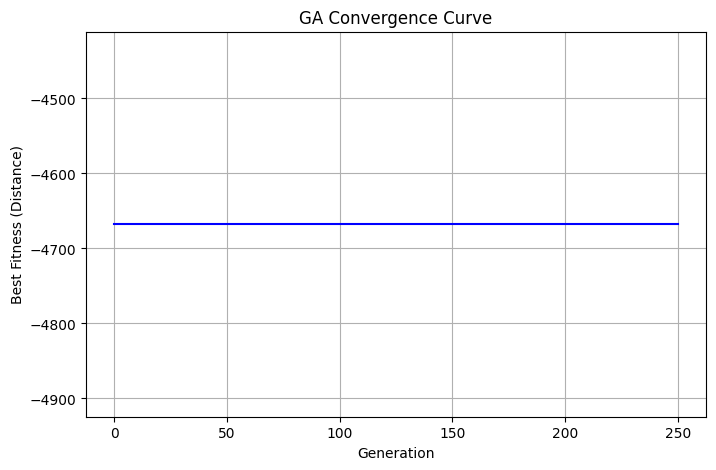

Best distance: -4667.6785939191805


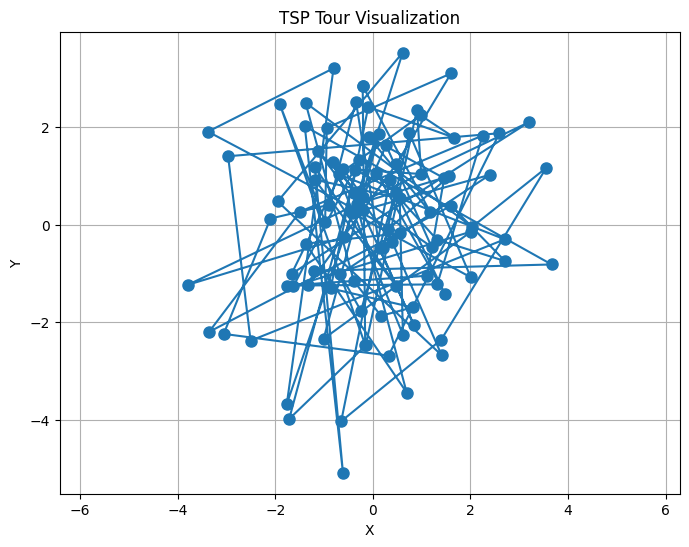

In [75]:
problem = load_matrix()
best_tour, best_distance, history = advanced_ga(
    distance_matrix=problem,
    pop_size=150,
    generations=1000,
    crossover_rate=0.9,
    swap_rate=0.2,
    two_opt_rate=0.05,
    elite_size=5,
    patience=50,
    n_jobs=-1
)

print("Best distance:", best_distance)
plot_tour(best_tour, problem)


Here ends the code for the lab, following is the code I used to save the results in a pdf format.

In [ ]:
import os
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, Table, TableStyle
)
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
import re

#Utility plotting functions
def natural_key(string):
    """Sort strings containing numbers in human order (problem_2 before problem_10)."""
    return [int(s) if s.isdigit() else s.lower() for s in re.split(r'(\d+)', string)]

def plot_tour(tour, distance_matrix, save_path):
    """Plot the 2D TSP tour and save as PNG."""
    distance_matrix = (distance_matrix + distance_matrix.T) / 2.0  # ensure symmetry

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_init=4)
    coords = mds.fit_transform(distance_matrix)
    tour_coords = coords[tour]
    tour_coords = np.vstack([tour_coords, tour_coords[0]])

    plt.figure(figsize=(4, 4))
    plt.plot(tour_coords[:, 0], tour_coords[:, 1], "o-", linewidth=2, markersize=5)
    plt.title("Best Tour")
    plt.axis("equal")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def plot_convergence(history, save_path):
    """Plot convergence curve and save as PNG."""
    plt.figure(figsize=(4, 3))
    plt.plot(history, label="Best Fitness", color="tab:blue")
    plt.xlabel("Generation")
    plt.ylabel("Distance")
    plt.title("Convergence Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

#Main function
def solve_all_to_pdf(problem_folder="problems", output_file="TSP_report.pdf"):
    os.makedirs("results", exist_ok=True)

    problem_files = [f for f in os.listdir(problem_folder) if f.endswith(".npy")]
    problem_files.sort(key=natural_key)

    #Setup PDF document
    doc = SimpleDocTemplate(output_file, pagesize=A4)
    story = []
    styles = getSampleStyleSheet()
    title_style = styles['Heading1']
    text_style = styles['Normal']

    for problem_file in problem_files:
        name = os.path.splitext(problem_file)[0]
        print(f"Solving {name}...")

        #Load distance matrix
        matrix = np.load(os.path.join(problem_folder, problem_file))

        #Run GA
        best_tour, best_distance, history = advanced_ga(
            distance_matrix=matrix,
            pop_size=150,
            generations=1000,
            crossover_rate=0.9,
            swap_rate=0.2,
            two_opt_rate=0.05,
            elite_size=5,
            patience=50,
            n_jobs=-1
        )

        #Temporary images
        conv_img = f"results/{name}_conv.png"
        tour_img = f"results/{name}_tour.png"
        plot_convergence(history, conv_img)
        plot_tour(best_tour, matrix, tour_img)

        #Add content to the PDF
        story.append(Paragraph(f"TSP Instance: {name}", title_style))
        story.append(Paragraph(f"Best Distance: {best_distance:.2f}", text_style))
        story.append(Spacer(1, 12))

        #Create a table with two images side-by-side
        img_width, img_height = 240, 240
        table_data = [[Image(conv_img, width=img_width, height=img_height),
                       Image(tour_img, width=img_width, height=img_height)]]

        table = Table(table_data)
        table.setStyle(TableStyle([
            ("ALIGN", (0, 0), (-1, -1), "CENTER"),
            ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
            ("BOTTOMPADDING", (0, 0), (-1, -1), 10),
            ("TOPPADDING", (0, 0), (-1, -1), 10),
            ("LEFTPADDING", (0, 0), (-1, -1), 10),
            ("RIGHTPADDING", (0, 0), (-1, -1), 10),
            ("BOX", (0, 0), (-1, -1), 0.25, colors.grey),
        ]))
        story.append(table)
        story.append(PageBreak())

    doc.build(story)
    print(f"\n✅ Report saved to {output_file}")



Solving problem_g_10...


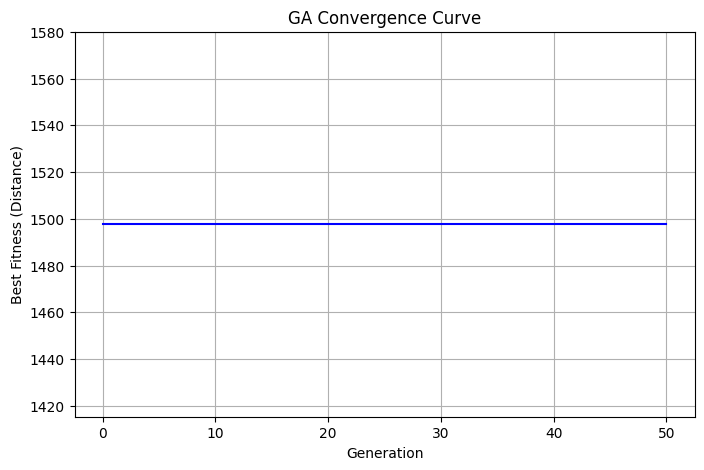

Solving problem_g_20...


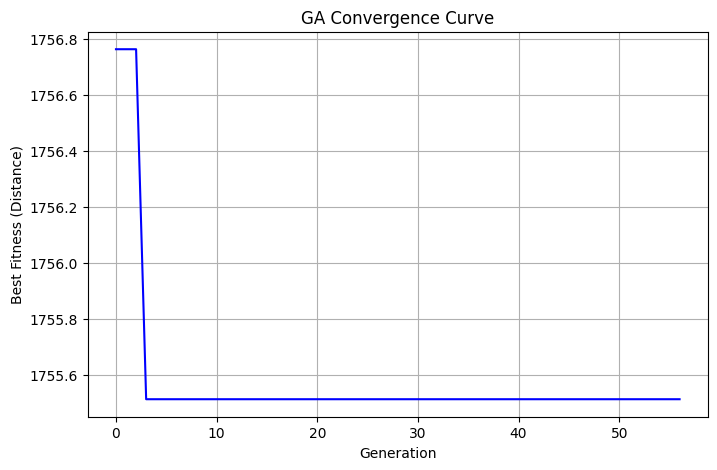

Solving problem_g_50...


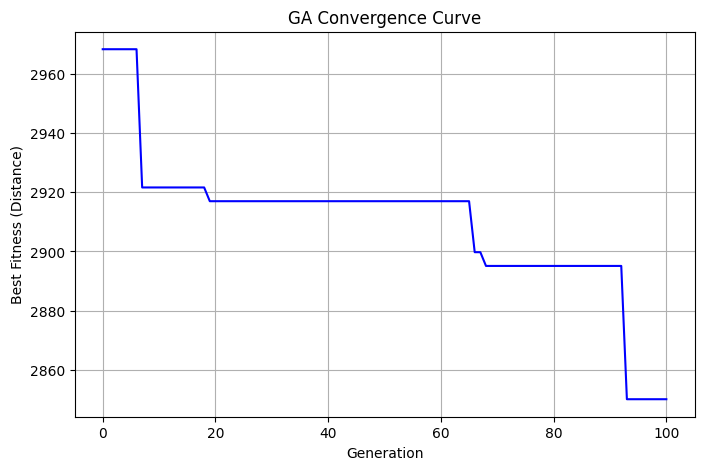

Solving problem_g_100...


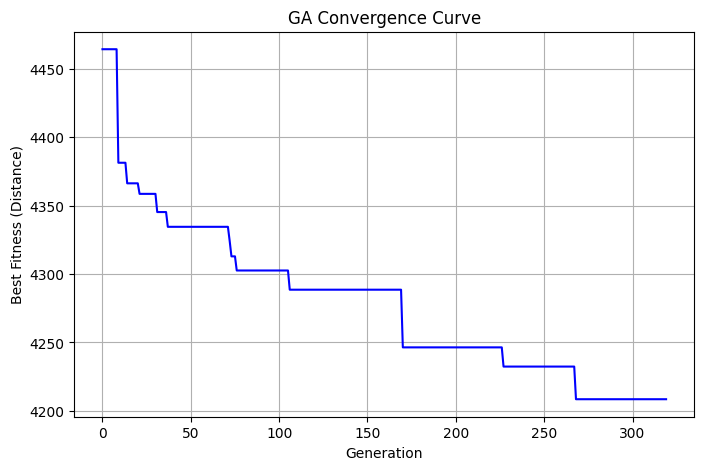

Solving problem_g_200...


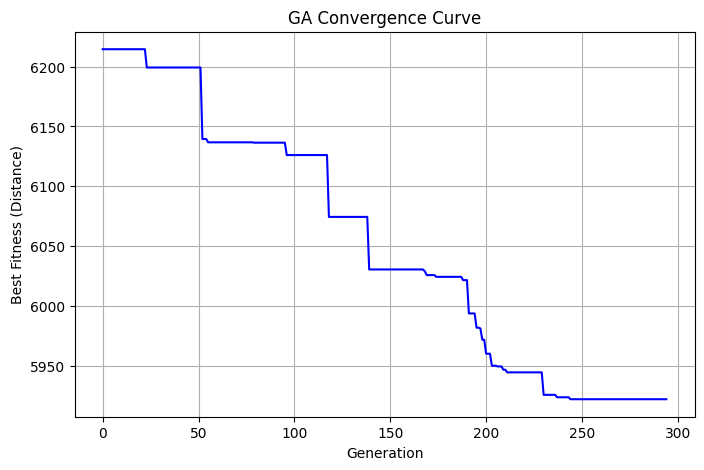

Solving problem_g_500...


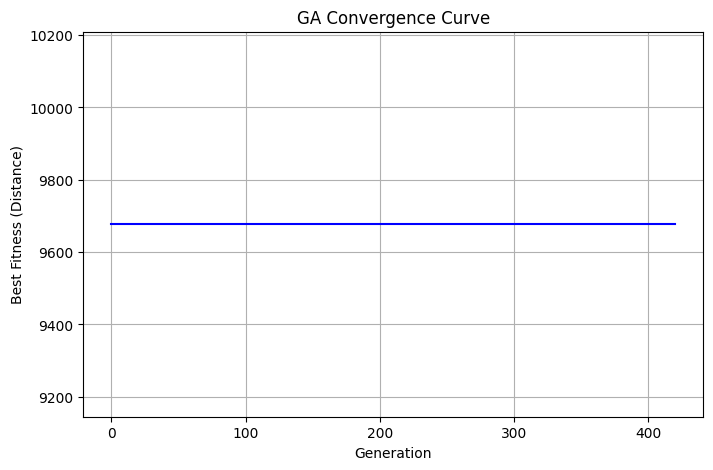

Solving problem_g_1000...


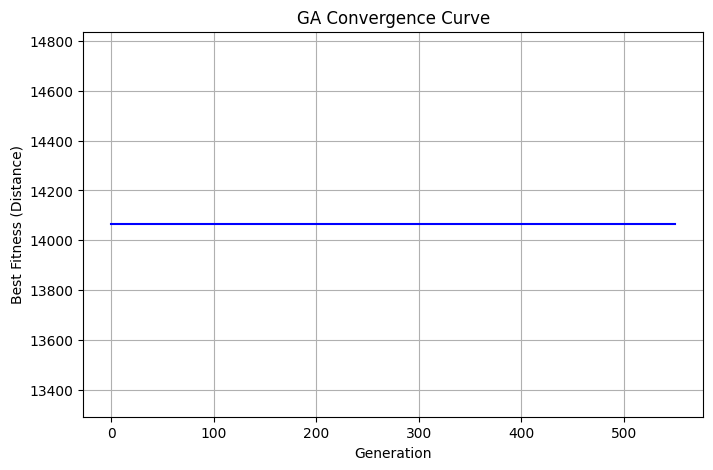

Solving problem_r1_10...


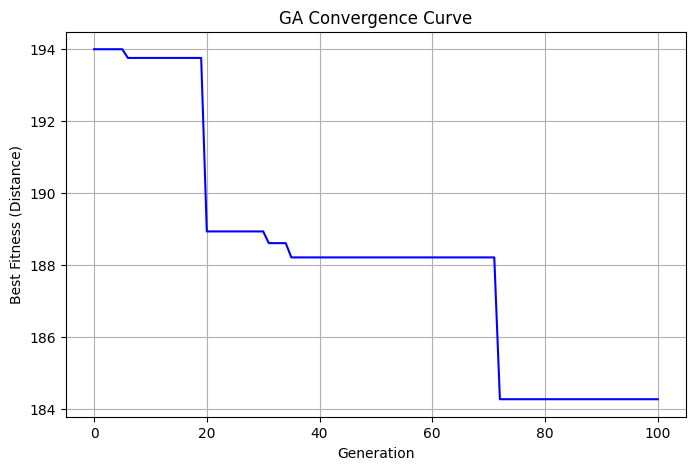

Solving problem_r1_20...


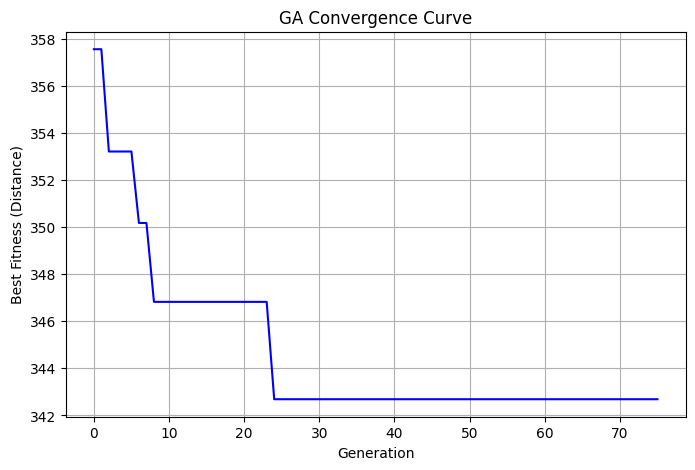

Solving problem_r1_50...


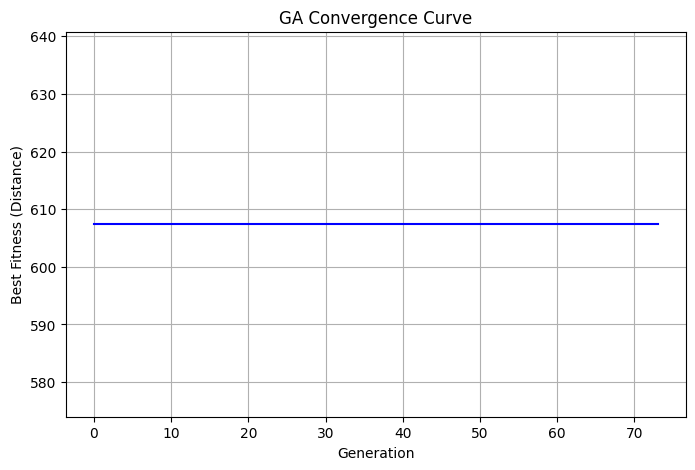

Solving problem_r1_100...


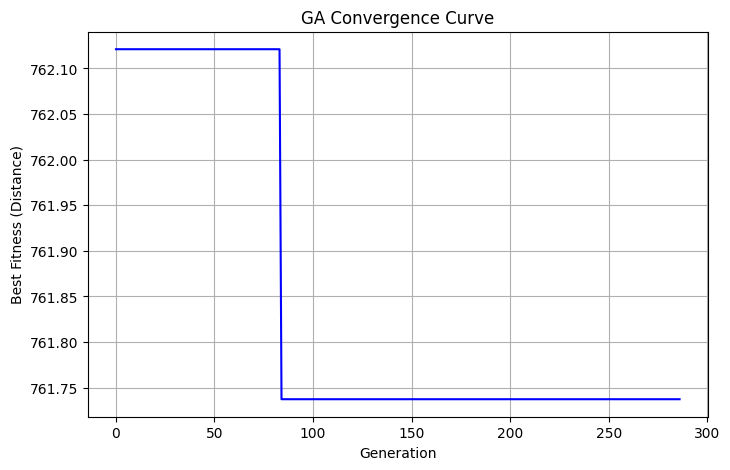

Solving problem_r1_200...


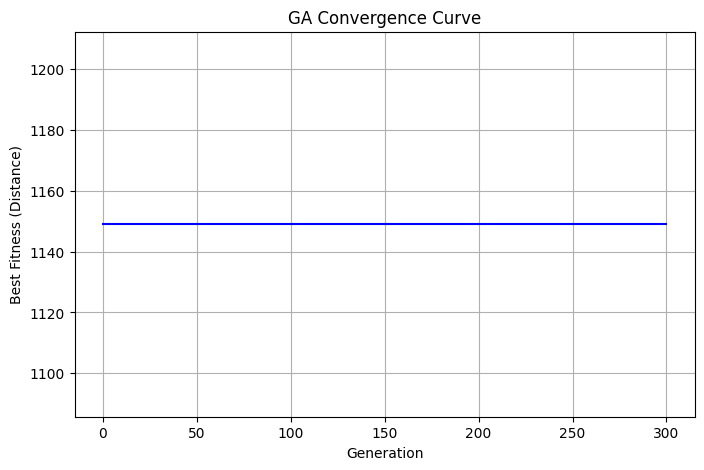

Solving problem_r1_500...


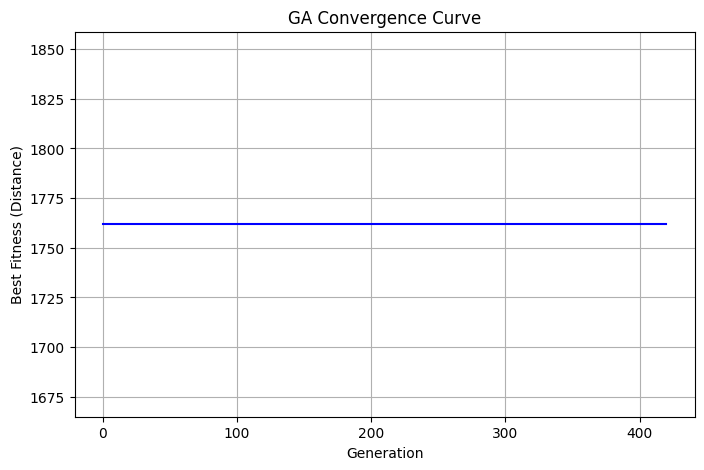

Solving problem_r1_1000...


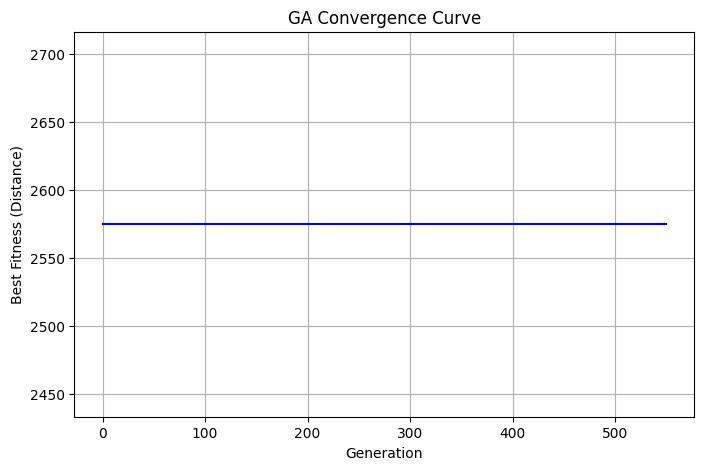

Solving problem_r2_10...


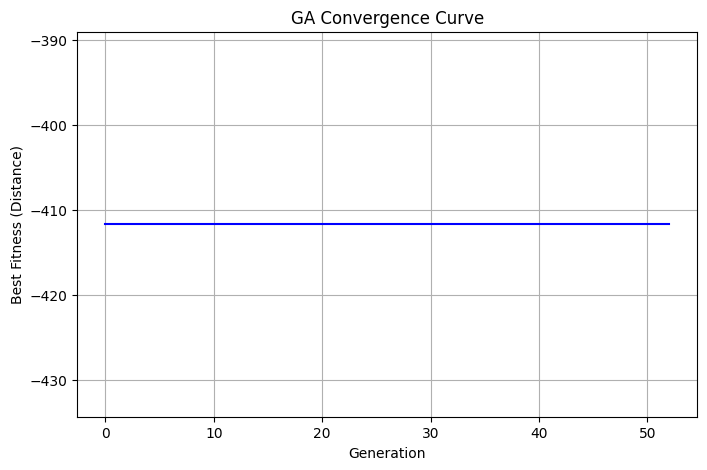

Solving problem_r2_20...


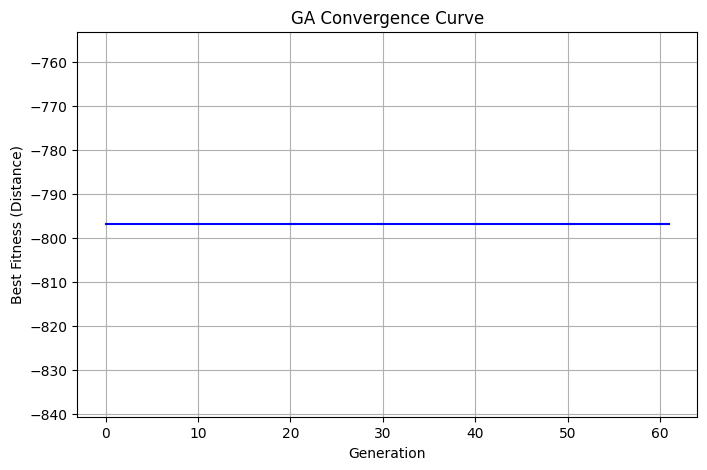

Solving problem_r2_50...


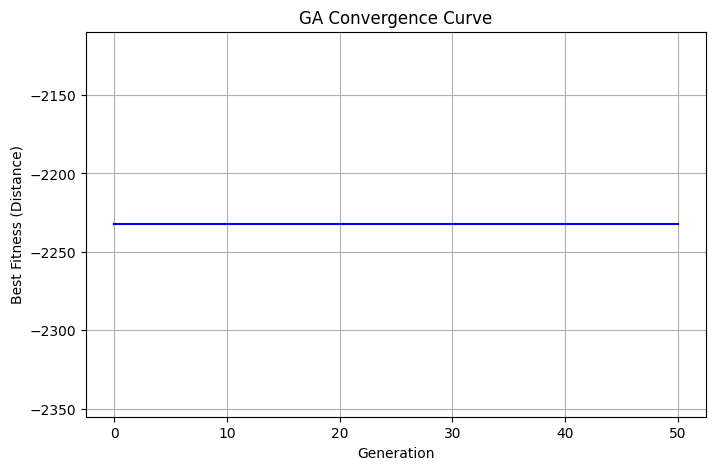

Solving problem_r2_100...


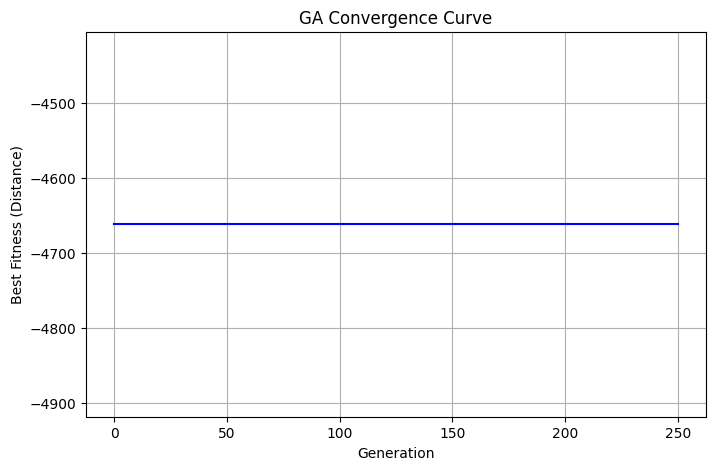

Solving problem_r2_200...


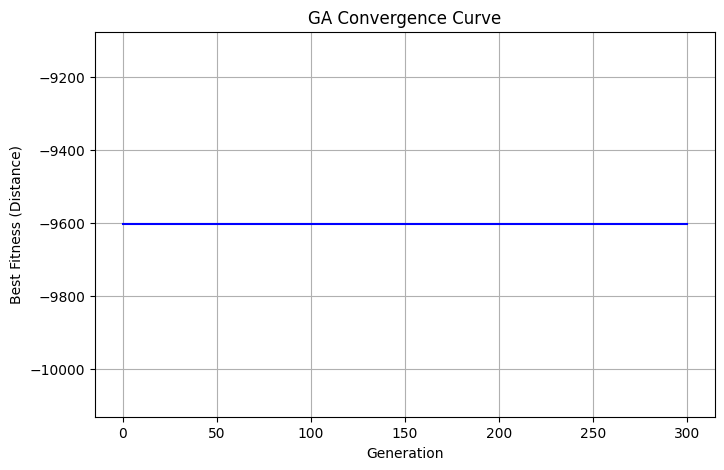

Solving problem_r2_500...


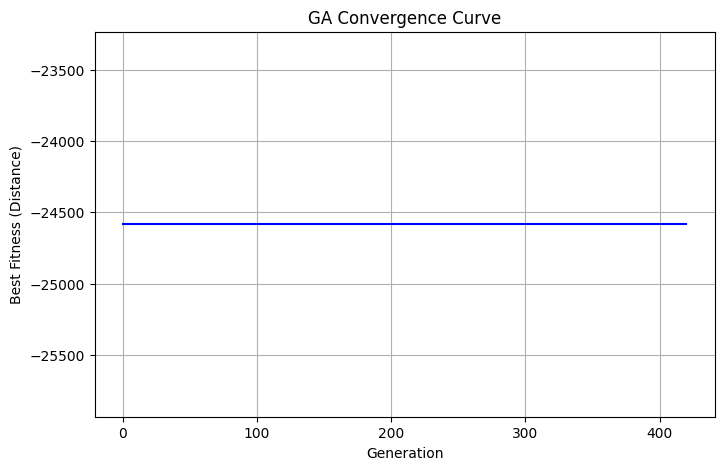

Solving problem_r2_1000...


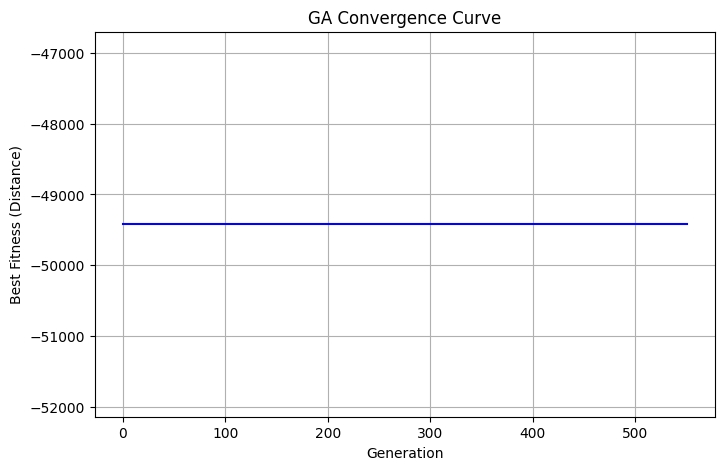

Solving test_problem...


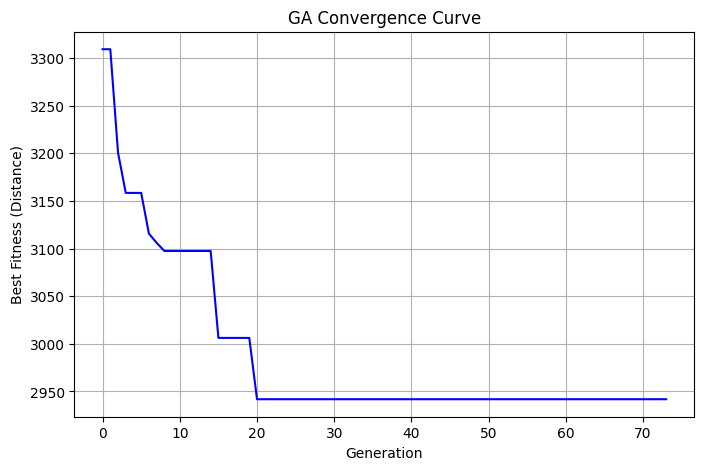


✅ Report saved to TSP_report.pdf


In [78]:
solve_all_to_pdf(problem_folder="problems", output_file="TSP_report.pdf")